In [1]:
import pandas as pd
import os
import pytz

In [2]:
import numpy as np
import seaborn as sns
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

sns.set()

# 그래프 기본 설정
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 실제 TTF 파일 경로 (예: 나눔고딕)
font_path = '/content/drive/MyDrive/NanumFontSetup_TTF_ALL/NanumGothic.ttf'

# 폰트 등록 및 적용
font_name = fm.FontProperties(fname=font_path).get_name()
fm.fontManager.addfont(font_path)
mpl.rc('font', family=font_name)

In [3]:
notop_multi_df = pd.read_parquet('/content/drive/MyDrive/data/noTop3_multi_buyers_all_events.parquet')

### 카테고리 3 결측치 처리

In [4]:
# category_lvl3가 결측치인 경우 category_lvl2로 대체
notop_multi_df['category_lvl3'] = notop_multi_df['category_lvl3'].fillna(notop_multi_df['category_lvl2'])

# 분석 목표:
고객 재구매 유도 통한 고객 리텐션 향상

데이터 분석 목표: 1회 구매자 vs 2회 이상 구매자 나누어 분석 후, 재구매 요인 분석과 재구매 유도 방안 도출 (재구매하는 안 하는 이유와 재구매하는 이유 분석)

# 고객 유형 별 레벨 3 상품 구매 건수
다양한 상품 구매 고객 vs 같은 상품 반복 고객 구분
→ 고객 타입별 리텐션 전략 차별화

제품군이 다양한 고객 vs 집중된 고객 비교
→ 어떤 그룹이 재구매 가능성 높은지 파악

In [5]:
# 구매 데이터만 필터링
purchase_df = notop_multi_df[notop_multi_df['event_type'] == 'purchase']

# 고객별 총 구매 수
user_total_purchases = purchase_df.groupby('user_id')['product_id'].count().reset_index(name='total_purchases')

# 고객별 고유한 product_id 수
user_unique_products = purchase_df.groupby('user_id')['product_id'].nunique().reset_index(name='unique_products')

# 병합
user_profile = pd.merge(user_total_purchases, user_unique_products, on='user_id')

# 고객 유형 분류
def classify_user(row):
    if row['unique_products'] == 1:
        return 'same_product_repeated'
    else:
        return 'various_products'

user_profile['user_type'] = user_profile.apply(classify_user, axis=1)

# 결과 확인
print(user_profile['user_type'].value_counts())

user_type
various_products         148814
same_product_repeated     56686
Name: count, dtype: int64


In [6]:
# user_type 정보 결합
purchase_df = purchase_df.merge(user_profile[['user_id', 'user_type']], on='user_id', how='left')

# 사용자 유형 + 카테고리 기준으로 집계
user_type_cat = purchase_df.groupby(['user_type', 'category_lvl3']).size().reset_index(name='purchase_count')

# 상위 10개씩 확인
print(user_type_cat.sort_values(by='purchase_count', ascending=False).groupby('user_type').head(10))

                 user_type category_lvl3  purchase_count
88        various_products       bicycle          130539
134       various_products         shoes           79575
128       various_products       printer           44463
8    same_product_repeated       bicycle           43974
130       various_products       sandals           29438
122       various_products      notebook           25376
139       various_products       slipons           25173
89        various_products       blanket           22000
113       various_products          keds           20317
150       various_products          toys           19709
54   same_product_repeated         shoes           17010
85        various_products           bed           13861
48   same_product_repeated       printer            5913
50   same_product_repeated       sandals            5410
59   same_product_repeated       slipons            4821
9    same_product_repeated       blanket            4734
42   same_product_repeated     

/tmp/ipython-input-2505410124.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_cats = user_type_cat.groupby('user_type').apply(lambda x: x.sort_values(by='purchase_count', ascending=False).head(10)).reset_index(drop=True)


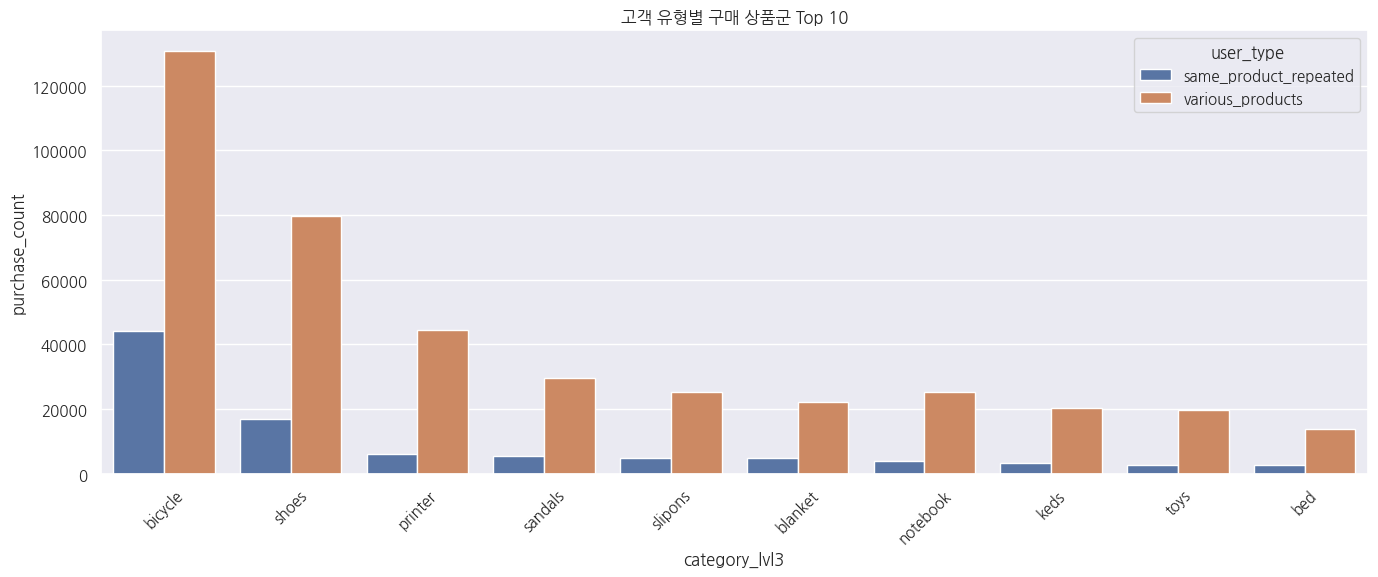

In [7]:
# 상위 10개만 시각화
top_cats = user_type_cat.groupby('user_type').apply(lambda x: x.sort_values(by='purchase_count', ascending=False).head(10)).reset_index(drop=True)

plt.figure(figsize=(14, 6))
sns.barplot(data=top_cats, x='category_lvl3', y='purchase_count', hue='user_type')
plt.title('고객 유형별 구매 상품군 Top 10')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 가격 구간별 전환율

In [8]:
# 1. 가격 구간 나누기 (10만원 단위, 필요시 조정 가능)
# 올바른 bins와 labels 정의
bins = [0, 100, 200, 300, 400, 500, 1000, float('inf')]  # 8개 → 7개 구간
labels = ['0~100', '100~200', '200~300', '300~400', '400~500', '500~1000', '1000+']  # 7개

# 가격 구간 생성
notop_multi_df['price_bin'] = pd.cut(notop_multi_df['price'], bins=bins, labels=labels, right=False)


# 2. 구매, 조회 이벤트만 나누기
purchase_df = notop_multi_df[notop_multi_df['event_type'] == 'purchase']
view_df = notop_multi_df[notop_multi_df['event_type'] == 'view']

# 3. 가격 구간별 이벤트 수 집계
purchase_stats = purchase_df['price_bin'].value_counts().sort_index().reset_index()
purchase_stats.columns = ['price_bin', 'purchase_count']

view_stats = view_df['price_bin'].value_counts().sort_index().reset_index()
view_stats.columns = ['price_bin', 'view_count']

# 4. 병합 및 전환율 계산
price_group_stats = pd.merge(purchase_stats, view_stats, on='price_bin', how='outer')

# 숫자 컬럼만 골라서 NaN을 0으로 대체
numeric_cols = ['purchase_count', 'view_count']
price_group_stats[numeric_cols] = price_group_stats[numeric_cols].fillna(0)

# 전율 계산
price_group_stats['conversion_rate'] = price_group_stats['purchase_count'] / price_group_stats['view_count']

# 결과 확인
print(price_group_stats)

  price_bin  purchase_count  view_count  conversion_rate
0     0~100          435634     9780808         0.044540
1   100~200          227304     3564664         0.063766
2   200~300           60974     1275165         0.047817
3   300~400           53140      922148         0.057626
4   400~500           25490      548932         0.046436
5  500~1000           30704      976372         0.031447
6     1000+            9625      405567         0.023732


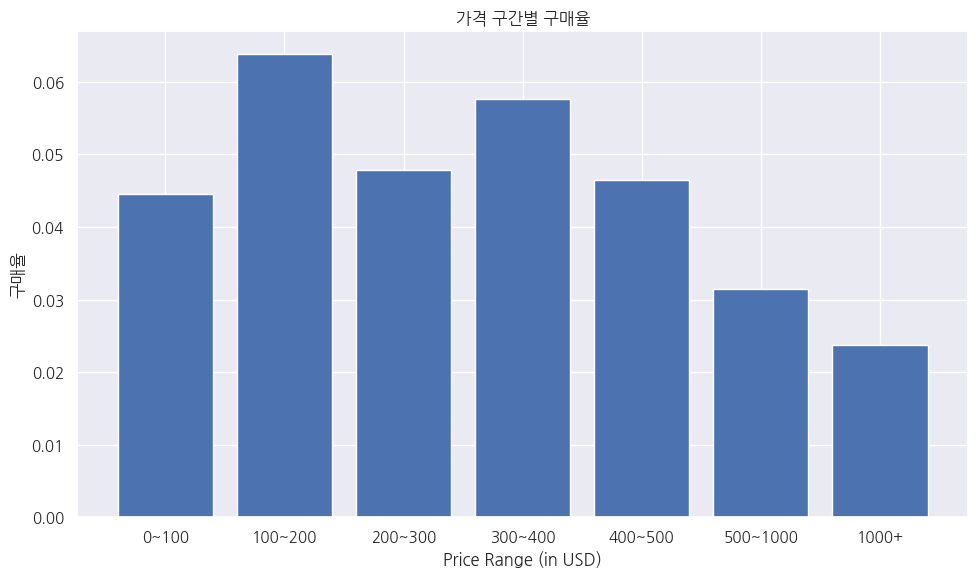

In [9]:
plt.figure(figsize=(10, 6))
plt.bar(price_group_stats['price_bin'].astype(str), price_group_stats['conversion_rate'])
plt.title('가격 구간별 전환율')
plt.xlabel('Price Range (in USD)')
plt.ylabel('전환율')
plt.tight_layout()
plt.show()

# 카테고리 레벨3별 전환 퍼널 분석(전환율)

In [10]:
# 1. 이벤트별 필터링
views = notop_multi_df[notop_multi_df['event_type'] == 'view']
carts = notop_multi_df[notop_multi_df['event_type'] == 'cart']
purchases = notop_multi_df[notop_multi_df['event_type'] == 'purchase']

# 2. 상품별 이벤트 수 집계
view_counts = views.groupby('product_id').size().reset_index(name='view_count')
cart_counts = carts.groupby('product_id').size().reset_index(name='cart_count')
purchase_counts = purchases.groupby('product_id').size().reset_index(name='purchase_count')

# 3. 병합
product_stats = view_counts.merge(cart_counts, on='product_id', how='outer')
product_stats = product_stats.merge(purchase_counts, on='product_id', how='outer')
product_stats.fillna(0, inplace=True)

# 4. 퍼널 전환율 계산
product_stats['view_to_cart_rate'] = product_stats['cart_count'] / product_stats['view_count']
product_stats['cart_to_purchase_rate'] = product_stats['purchase_count'] / product_stats['cart_count']
product_stats['view_to_purchase_rate'] = product_stats['purchase_count'] / product_stats['view_count']

# 5. 상품 정보 결합 (선택)
product_stats = pd.merge(
    product_stats,
    notop_multi_df[['product_id', 'category_lvl1', 'category_lvl2', 'category_lvl3']].drop_duplicates(),
    on='product_id', how='left'
)

# 6. 결과 확인 (view 수 기준으로 필터링하여 너무 적은 데이터 제거 가능)
product_stats_filtered = product_stats[product_stats['view_count'] >= 30]
print(product_stats_filtered[['product_id', 'category_lvl3', 'view_to_cart_rate', 'cart_to_purchase_rate', 'view_to_purchase_rate']].sort_values(by='view_to_purchase_rate', ascending=False).head(10))

        product_id category_lvl3  view_to_cart_rate  cart_to_purchase_rate  \
3501       2900539       blanket           0.303030               1.700000   
135849   100048272        tennis           0.681159               0.702128   
58297     22500184         table           0.328125               1.333333   
135864   100048302        tennis           0.337838               1.120000   
146395   100073552     moccasins           0.342105               1.076923   
72619     26500528           ski           0.469388               0.782609   
157968   100097182       printer           0.208955               1.642857   
173809   100148404         glove           0.419355               0.769231   
152607   100088187       bicycle           0.226667               1.411765   
75200     27201890         swing           0.629630               0.490196   

        view_to_purchase_rate  
3501                 0.515152  
135849               0.478261  
58297                0.437500  
135864       

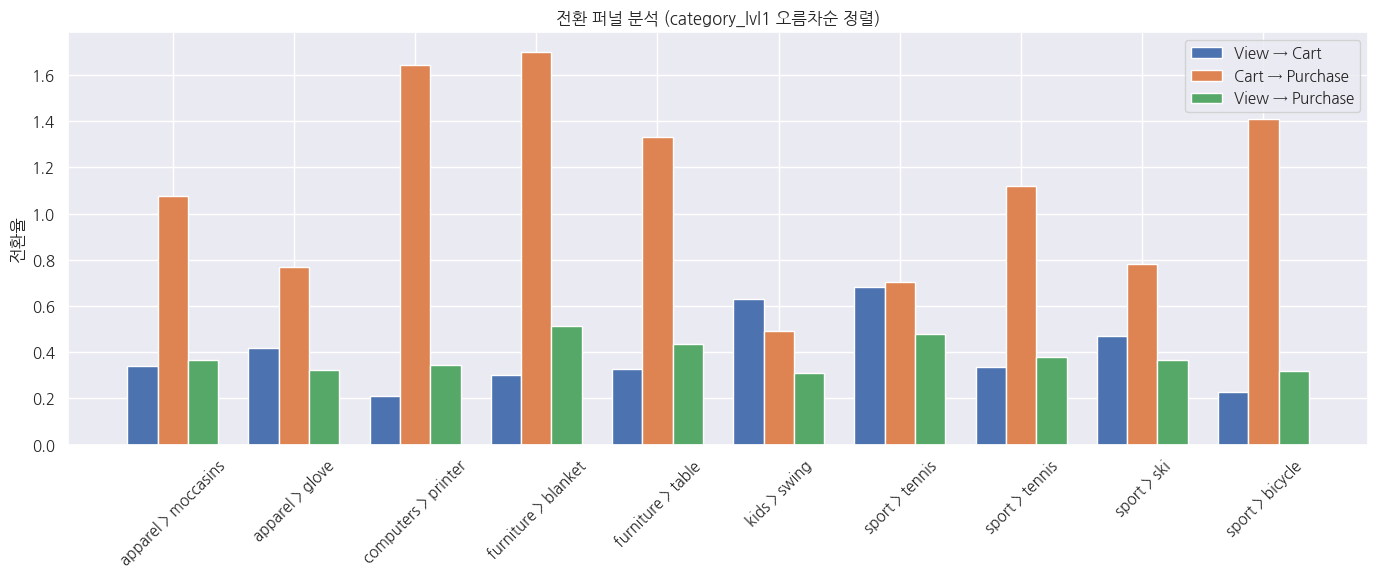

In [11]:
# 1. 새로운 라벨 컬럼 생성
top_funnel = product_stats_filtered.sort_values(by='view_to_purchase_rate', ascending=False).head(10)

top_funnel['category_label'] = top_funnel['category_lvl1'] + ' > ' + top_funnel['category_lvl3']

# 2. category_lvl1 기준 오름차순 정렬
top_funnel_sorted = top_funnel.sort_values(by='category_lvl1')

# 3. 시각화
plt.figure(figsize=(14, 6))
bar_width = 0.25
x = range(len(top_funnel_sorted))

plt.bar(x, top_funnel_sorted['view_to_cart_rate'], width=bar_width, label='View → Cart')
plt.bar([p + bar_width for p in x], top_funnel_sorted['cart_to_purchase_rate'], width=bar_width, label='Cart → Purchase')
plt.bar([p + bar_width*2 for p in x], top_funnel_sorted['view_to_purchase_rate'], width=bar_width, label='View → Purchase')

# 정렬된 라벨 적용
plt.xticks([p + bar_width for p in x], top_funnel_sorted['category_label'], rotation=45)
plt.ylabel('전환율')
plt.title('전환 퍼널 분석 (category_lvl1 오름차순 정렬)')
plt.legend()
plt.tight_layout()
plt.show()

# 고객 수익성 상위 카테고리1

In [14]:
# 유저별 전체 구매금액
user_value = purchase_df.groupby('user_id')['price'].sum().reset_index()
user_value.columns = ['user_id', 'total_spent']

# 카테고리별 평균 고객 구매금액 계산
avg_value_cat = purchase_df.groupby('category_lvl1')['user_id'].apply(
    lambda x: user_value[user_value['user_id'].isin(x)]['total_spent'].mean()
).reset_index(name='avg_user_value')

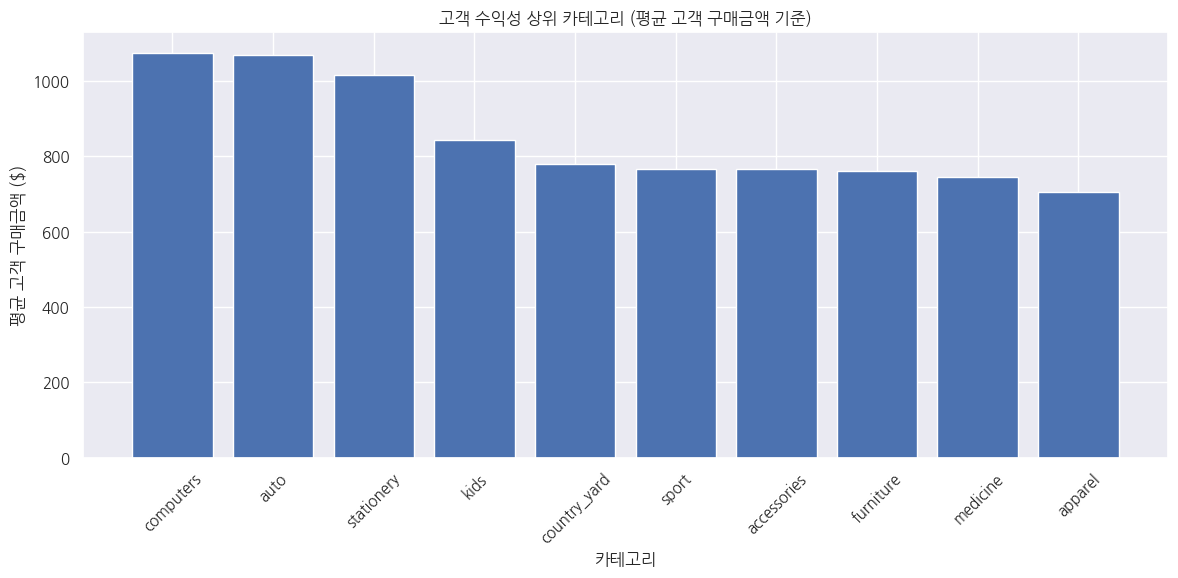

In [15]:
# 상위 카테고리 10개 시각화
top_value_cat = avg_value_cat.sort_values('avg_user_value', ascending=False).head(10)

plt.figure(figsize=(12, 6))
plt.bar(top_value_cat['category_lvl1'].astype(str), top_value_cat['avg_user_value'])
plt.title('고객 수익성 상위 카테고리 (평균 고객 구매금액 기준)')
plt.xlabel('카테고리')
plt.ylabel('평균 고객 구매금액 ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 카테고리 레벨2, 3별 매출 총합 순위

In [16]:
# 1. 상품별 매출 계산 (price × 건수)
purchase_df = notop_multi_df[notop_multi_df['event_type'] == 'purchase']
product_revenue = purchase_df.groupby('product_id')['price'].sum().reset_index(name='total_revenue')

# 2. 상품 정보 붙이기 (카테고리 포함)
product_info = notop_multi_df[['product_id', 'category_lvl1', 'category_lvl2', 'category_lvl3']].drop_duplicates()
product_revenue = pd.merge(product_revenue, product_info, on='product_id', how='left')

# 3. 매출 총합 상위 10개 상품 출력
top_products = product_revenue.sort_values(by='total_revenue', ascending=False).head(10)
print(top_products)

      product_id  total_revenue category_lvl1 category_lvl2 category_lvl3
4259     4804056    10533694.98         sport       bicycle       bicycle
4519     4804718     4467514.10         sport       bicycle       bicycle
4258     4804055     3918140.91         sport       bicycle       bicycle
2938     4100346     2957900.94       apparel         shoes         shoes
2834     4100126     1188418.50       apparel         shoes         shoes
4234     4803977      923315.75         sport       bicycle       bicycle
593      1307073      809439.29     computers      notebook      notebook
2836     4100129      727740.50       apparel         shoes         shoes
4695     5100816      651640.98       apparel         shoes         shoes
174      1201567      605939.50       apparel         shoes       slipons


### 카테고리 레벨 2 매출 상위 10

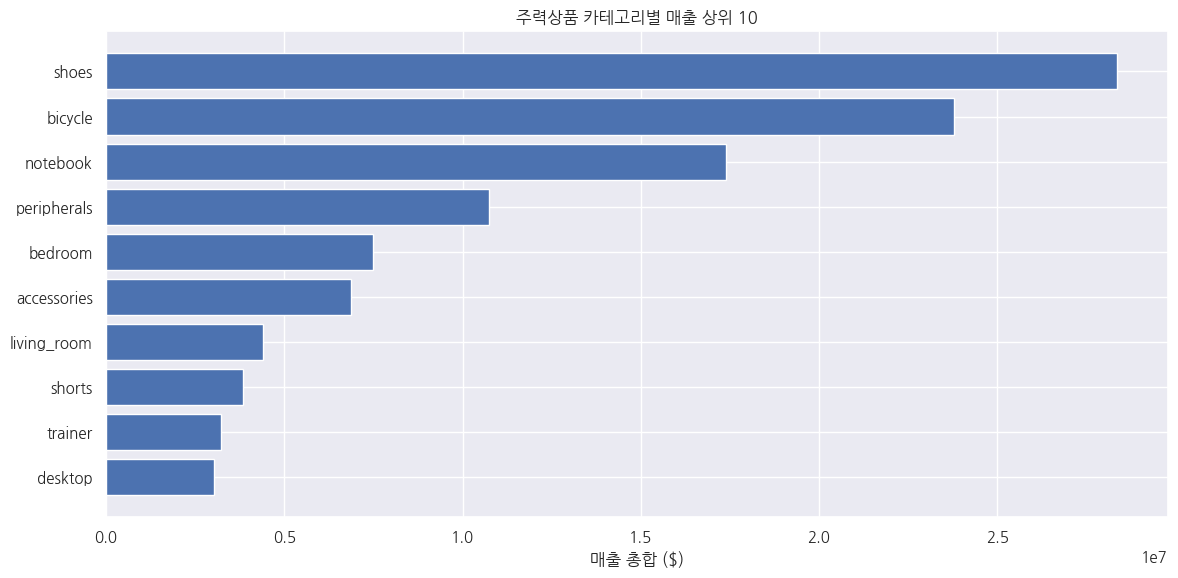

In [17]:
# 4. 카테고리별 매출 총합 (category_lvl2 기준)
category_revenue = purchase_df.groupby('category_lvl2')['price'].sum().reset_index(name='total_revenue')
category_revenue = category_revenue.sort_values(by='total_revenue', ascending=False).head(10)

# 5. 시각화
plt.figure(figsize=(12,6))
plt.barh(category_revenue['category_lvl2'], category_revenue['total_revenue'])
plt.xlabel('매출 총합 ($)')
plt.title('주력상품 카테고리별 매출 상위 10')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### 카테고리 레벨 3 매출 상위 10

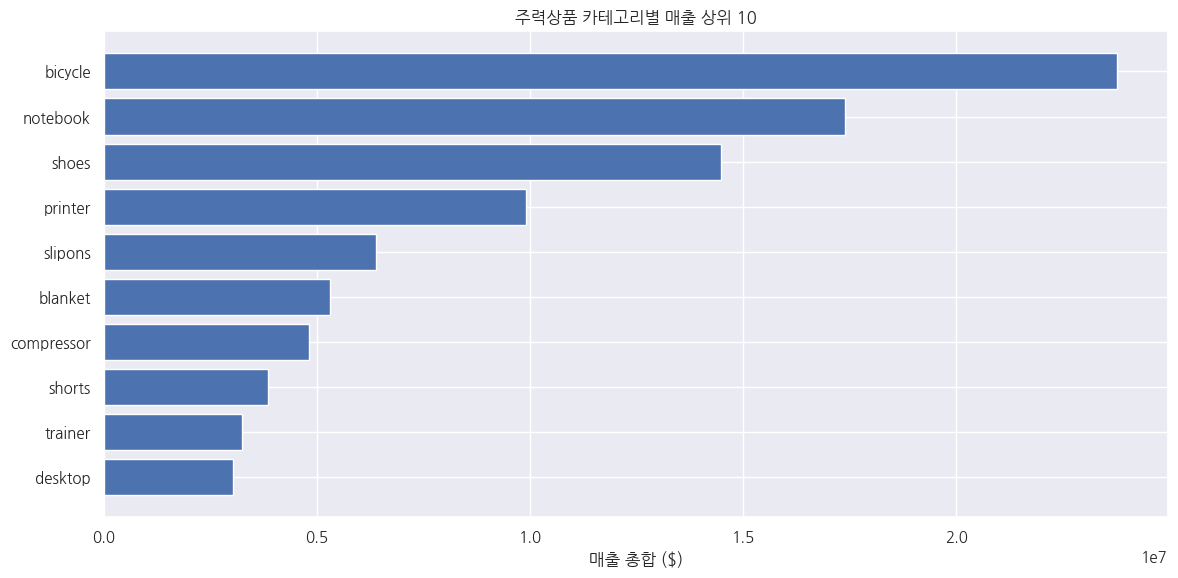

In [18]:
# 4. 카테고리별 매출 총합 (category_lvl3 기준)
category_revenue = purchase_df.groupby('category_lvl3')['price'].sum().reset_index(name='total_revenue')
category_revenue = category_revenue.sort_values(by='total_revenue', ascending=False).head(10)

# 5. 시각화
plt.figure(figsize=(12,6))
plt.barh(category_revenue['category_lvl3'], category_revenue['total_revenue'])
plt.xlabel('매출 총합 ($)')
plt.title('주력상품 카테고리별 매출 상위 10')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 카테고리 레벨1 별 평균 재구매 간격(일)

In [24]:
# 1. 날짜 변환
notop_multi_df['event_date'] = pd.to_datetime(notop_multi_df['event_date'])

# 2. 구매 이벤트 필터링
purchase_df = notop_multi_df[notop_multi_df['event_type'] == 'purchase'].copy()

# 3. 구매 이력 정렬 및 간격 계산
purchase_sorted = purchase_df.sort_values(by=['user_id', 'product_id', 'event_date'])
purchase_sorted['days_diff'] = purchase_sorted.groupby(['user_id', 'product_id'])['event_date'].diff().dt.days

# 4. 상품 기준 평균 재구매 간격
product_days = purchase_sorted.groupby('product_id')['days_diff'].mean().reset_index()
product_days.columns = ['product_id', 'avg_repurchase_gap']

# 5. 카테고리 기준 재구매 간격 계산
repeat_df = purchase_sorted[purchase_sorted['days_diff'].notnull()]  # 재구매가 일어난 경우만
category_repeat_interval = repeat_df.groupby('category_lvl1')['days_diff'].mean().reset_index()
category_repeat_interval.columns = ['category_lvl1', 'avg_days_between_purchase']

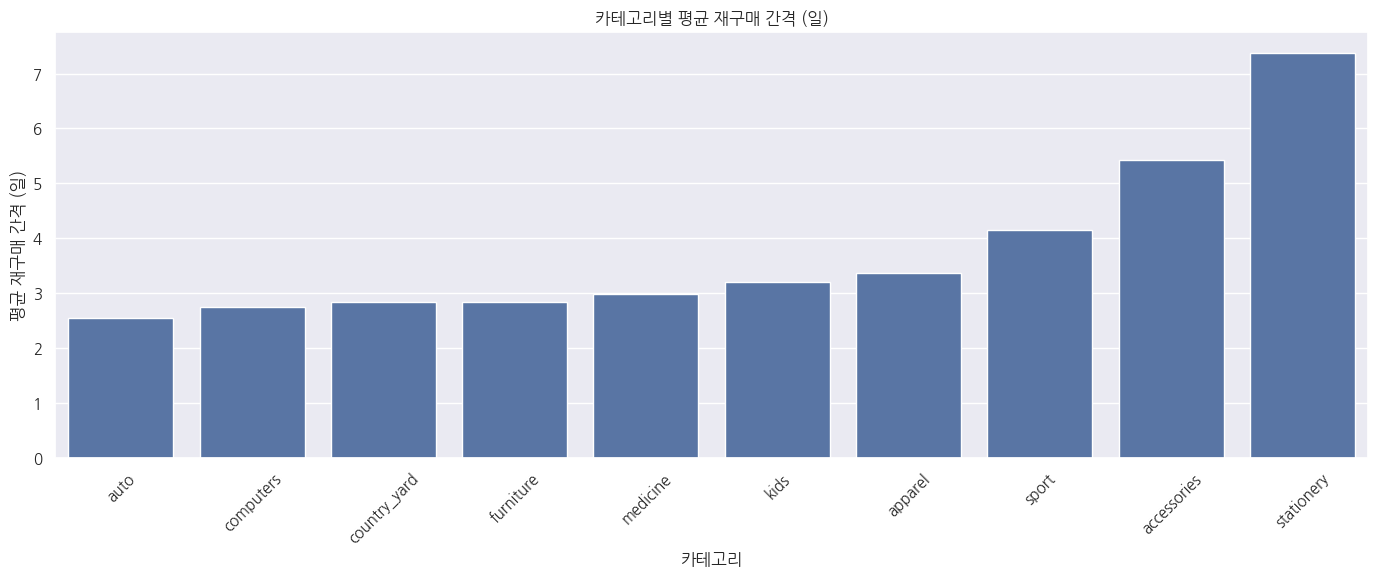

In [25]:
# 6. 시각화
plt.figure(figsize=(14, 6))
sns.barplot(data=category_repeat_interval.sort_values('avg_days_between_purchase'),
            x='category_lvl1', y='avg_days_between_purchase')
plt.xticks(rotation=45)
plt.title('카테고리별 평균 재구매 간격 (일)')
plt.xlabel('카테고리')
plt.ylabel('평균 재구매 간격 (일)')
plt.tight_layout()
plt.show()